# Amazon Sagemaker Segmentation 알고리즘 사용법
이 노트북은 아래 참고 링크를 사용하여 영어로 설명된 중요 내용을 한글로 번역했습니다.
#### 참고 링크: https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/semantic_segmentation_pascalvoc/semantic_segmentation_pascalvoc.html

### 세팅

In [1]:
# ***********************************************노트북 재 실행시 RUN 필요*******************************************
# Sagemaker SDK 설치 업그레이드 실행

!pip install 'sagemaker>2,<3'

In [2]:
# ***********************************************노트북 재 실행시 RUN 필요*******************************************
# Segmentation 알고리즘을 학습하기 위해 AWS 서비스들의 setup 및 authentication을 해야됩니다. 시작으로 Sagemaker를 access하기위해 AWS account role이 필요합니다. 
#Sagemaker가 S3 데이터를 access할수있는 Role을 자동적으로 이 노트북을 시작한 Role로 사용 합니다.

#%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::472297214395:role/service-role/AmazonSageMaker-ExecutionRole-20220331T132927


In [3]:
# ***********************************************노트북 재 실행시 RUN 필요*******************************************
#Training 데이터를 와 학습된 model artifact를 저장하는 S3 bucket이 필요합니다. 이 노트북에서는 Sagemaker에서 제공하는 default bucket으로 사용합니다.

bucket = sess.default_bucket()
prefix = "semantic-segmentation-demo"
print(bucket)

sagemaker-us-east-1-472297214395


In [4]:
# ***********************************************노트북 재 실행시 RUN 필요*******************************************
#마지막으로 Amazon Sagemaker Semantic Segmentation 알고리즘 docker image 위치가 필요합니다. SDK를 사용해서 찾습니다.

training_image = sagemaker.image_uris.retrieve("semantic-segmentation", sess.boto_region_name)
print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:1


### 데이터 준비

#### Pascal VOC라는 인기있는 computer vision dataset이며 매년 진행하는 semantic segmentation challenge 2005-2012에 사용 됬습니다.
#### 데이터셋을 1464 학습데이터와 1449 검증 데이터로 분류되있고, 21가지 class로 나눠집니다. 
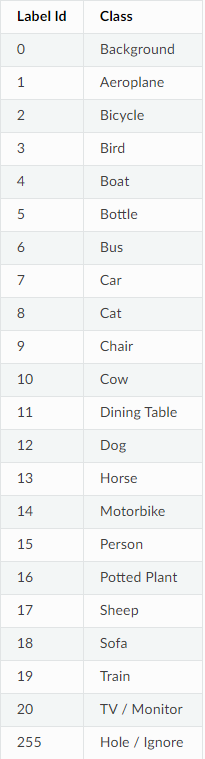

In [5]:
# Pascal VOC 2012 데이터셋 다운로드
# 아래 스크립트로 전에 다운 받은 데이터를 삭제 합니다
# !rm -rf data

In [6]:
# Pascal VOC 데이터셋 다운로드
# 데이터셋 링크: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/
# FastAI에서 직접 다운로드하는게 빨라서, 그렇게 진행

#%%time

print("Downloading the dataset...")
!wget -P /tmp https://fast-ai-imagelocal.s3.amazonaws.com/pascal-voc.tgz
# S3 cp may be even faster on environments where it's available:
# !aws s3 cp s3://fast-ai-imagelocal/pascal-voc.tgz /tmp/pascal-voc.tgz

print("Extracting VOC2012...")
!tar -xf /tmp/pascal-voc.tgz --wildcards pascal-voc/VOC2012*

print("Deleting /tmp files...")
!rm /tmp/pascal-voc.tgz

# Alternatively could consider using the Oxford Uni source:
#!wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#!tar -xf /tmp/VOCtrainval_11-May-2012.tar -C pascal-voc/VOC2012
#!rm /tmp/VOCtrainval_11-May-2012.tar

print("Done!")

--2022-03-31 07:25:48--  https://fast-ai-imagelocal.s3.amazonaws.com/pascal-voc.tgz
Resolving fast-ai-imagelocal.s3.amazonaws.com (fast-ai-imagelocal.s3.amazonaws.com)... 52.216.100.195
Connecting to fast-ai-imagelocal.s3.amazonaws.com (fast-ai-imagelocal.s3.amazonaws.com)|52.216.100.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4639722845 (4.3G) [application/x-tar]
Saving to: ‘/tmp/pascal-voc.tgz’

pascal-voc.tgz      100%[===================>]   4.32G  10.0MB/s    in 2m 58s  

2022-03-31 07:28:46 (24.8 MB/s) - ‘/tmp/pascal-voc.tgz’ saved [4639722845/4639722845]

Extracting VOC2012...
Deleting /tmp files...
Done!


In [ ]:
# 한번 실행
# 데이터 경로에 정리 하기
# train은 train directory로 분류하기

import os
import shutil

# Create directory structure mimicing the s3 bucket where data is to be dumped.
VOC2012 = "pascal-voc/VOC2012"
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/validation", exist_ok=True)
os.makedirs("data/train_annotation", exist_ok=True)
os.makedirs("data/validation_annotation", exist_ok=True)

# Create a list of all training images.
with open(VOC2012 + "/ImageSets/Segmentation/train.txt") as f:
    train_list = f.read().splitlines()

# Create a list of all validation images.
with open(VOC2012 + "/ImageSets/Segmentation/val.txt") as f:
    val_list = f.read().splitlines()

# Move the jpg images in training list to train directory and png images to train_annotation directory.
for i in train_list:
    shutil.copy2(VOC2012 + "/JPEGImages/" + i + ".jpg", "data/train/")
    shutil.copy2(VOC2012 + "/SegmentationClass/" + i + ".png", "data/train_annotation/")

# Move the jpg images in validation list to validation directory and png images to validation_annotation directory.
for i in val_list:
    shutil.copy2(VOC2012 + "/JPEGImages/" + i + ".jpg", "data/validation/")
    shutil.copy2(VOC2012 + "/SegmentationClass/" + i + ".png", "data/validation_annotation/")

In [13]:
# ***********************************************노트북 재 실행시 RUN 필요*******************************************
# 데이터가 재대로 분류 됬는지 확인

import glob

num_training_samples = len(glob.glob1("data/train", "*.jpg"))
num_validation_samples = len(glob.glob1("data/validation", "*.jpg"))

print("Num Train Images = " + str(num_training_samples))
assert num_training_samples == len(glob.glob1("data/train_annotation", "*.png"))

print("Num Validation Images = " + str(num_validation_samples))
assert num_validation_samples == len(glob.glob1("data/validation_annotation", "*.png"))

Num Train Images = 1464
Num Validation Images = 1449


S3 bucker으로 같은 구조로 데이터 넘기기

root
|-train/
|-train_annotation/
|-validation/
|-validation_annotation/

In [14]:
# ***********************************************노트북 재 실행시 RUN 필요*******************************************
# PASCAL annotation 데이터셋에 사용하는 image pixel value를 default로 사용하겠다고 셋팅

import json

label_map = {"scale": 1}
with open("data/train_label_map.json", "w") as lmfile:
    json.dump(label_map, lmfile)

### S3로 데이터 올리기

In [15]:
# ***********************************************노트북 재 실행시 RUN 필요*******************************************
# S3로 데이터셋 올리기

#%%time
train_channel = sess.upload_data(path="data/train", bucket=bucket, key_prefix=prefix + "/train")
print(train_channel)
train_annotation_channel = sess.upload_data(
    path="data/train_annotation",
    bucket=bucket,
    key_prefix=prefix + "/train_annotation",
)
print(train_annotation_channel)
validation_channel = sess.upload_data(
    path="data/validation", bucket=bucket, key_prefix=prefix + "/validation"
)
print(validation_channel)
validation_annotation_channel = sess.upload_data(
    path="data/validation_annotation",
    bucket=bucket,
    key_prefix=prefix + "/validation_annotation",
)
print(validation_annotation_channel)
# label_map_channel = sess.upload_data(
#     path='data/train_label_map.json',
#     bucket=bucket,
#     key_prefix=prefix+'/label_map'
# )
# print(label_map_channel)

s3://sagemaker-us-east-1-472297214395/semantic-segmentation-demo/train
s3://sagemaker-us-east-1-472297214395/semantic-segmentation-demo/train_annotation
s3://sagemaker-us-east-1-472297214395/semantic-segmentation-demo/validation
s3://sagemaker-us-east-1-472297214395/semantic-segmentation-demo/validation_annotation


In [16]:
# ***********************************************노트북 재 실행시 RUN 필요*******************************************
# 모델 output 저장 location 세팅 하기

s3_output_location = "s3://{}/{}/output".format(bucket, prefix)
print(s3_output_location)

s3://sagemaker-us-east-1-472297214395/semantic-segmentation-demo/output


## 학습
# ***********************************************노트북 재 실행시 모두 RUN 필요*******************************************

In [17]:
# sageMaker.estimator.Estimator object를 만들어서 Semantic Segmentation 알고리즘 container의 image를 올립니다
# GPU accelerated VM으로 돌려서 빠르게 결과 냅니다.

ss_estimator = sagemaker.estimator.Estimator(
    training_image,  # Container image URI
    role,  # Training job execution role with permissions to access our S3 bucket
    instance_count=1,
    #instance_type="ml.p3.2xlarge",
    #instance_type="ml.p2.xlarge",
    instance_type="ml.p3.2xlarge",
    volume_size=50,  # in GB
    max_run=360000,  # in seconds
    output_path=s3_output_location,
    base_job_name="ss-notebook-demo",
    sagemaker_session=sess,
)

In [18]:
# 이전에 학습된 모델을 불러와서 사용도 가능합니다

# Note: You can also 'attach' to a previously completed training job if, for example, you had to re-start the
# notebook and would like to skip straight to `ss_estimator.deploy()` later on:

#ss_estimator = sagemaker.estimator.Estimator.attach("ss-notebook-demo-2022-04-06-23-46-39-524")

AWS의 Semantic Segmentation 알고리즘 구성은 2가지로 나눠집니다:
- 인코더 or backbone network
- 디코더 or 알고리즘 network

인코더 or backbone network는 일반적으로 CNN으로 layer가 pre-trained 아니먄 학습이 안되있을수도 있습니다. AWS Segmenation 알고리즘은 pre-trained 또는 trained가 안된 network로 사용 가능합니다.
디코더 network는 backbone layer에서 나오는 output을 사용해 segmentation mask를 구성 합니다. 

In [19]:
# 하이퍼파라미터 설정을 합니다
# epoc 설정은 30정도 해야지 결과가 타당하게 나오지만, 시간과 비용을 고려해서 10 epoch로 설정합니다


ss_estimator.set_hyperparameters(
    backbone="resnet-50",  # This is the encoder. Other option is resnet-101
    algorithm="fcn",  # This is the decoder. Other options are 'psp' and 'deeplab'
    use_pretrained_model="True",  # Use the pre-trained model.
    crop_size=240,  # Size of image random crop.
    num_classes=21,  # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10,  # Number of epochs to run.
    learning_rate=0.0001,
    optimizer="rmsprop",  # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler="poly",  # Other options include 'cosine' and 'step'.
    mini_batch_size=16,  # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True,  # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=2,  # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10,  # No matter what, run these many number of epochs.
    num_training_samples=num_training_samples,  # This is a mandatory parameter, 1464 in this case.
)

In [20]:
# training channel설정, 

distribution = "FullyReplicated"

data_channels = {
    "train": sagemaker.inputs.TrainingInput(train_channel, distribution=distribution),
    "validation": sagemaker.inputs.TrainingInput(validation_channel, distribution=distribution),
    "train_annotation": sagemaker.inputs.TrainingInput(
        train_annotation_channel, distribution=distribution
    ),
    "validation_annotation": sagemaker.inputs.TrainingInput(
        validation_annotation_channel, distribution=distribution
    ),
    # 'label_map': label_map_channel
}

In [13]:
# Segmenation Model 학습 실행
ss_estimator.fit(data_channels, logs=True)

2022-04-06 23:46:40 Starting - Starting the training job...ProfilerReport-1649288799: InProgress
...
2022-04-06 23:47:29 Starting - Preparing the instances for training......
2022-04-06 23:48:32 Downloading - Downloading input data............
2022-04-06 23:50:32 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[04/06/2022 23:50:34 INFO 139947193173824 integration.py:636] worker started
[04/06/2022 23:50:34 INFO 139947193173824] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'backbone': 'resnet-50', 'algorithm': 'fcn', 'use_pretrained_model': 'True', 'crop_size': '240', 'epochs': '10', 'learning_rate': '0.001', 'optimizer': 'sgd', 'lr_scheduler': 'poly', 'lr_scheduler_factor': '0.1', 'weight_decay': '0.0001', 'momentum': '0.9', 'gamma1': '0.9', 'gamma2': '0.9', 'mini

In [14]:
# 학습된 Segmenation 모델을 Sagemaker Endpoint으로 구성함으로 prediction/inference 가능해짐
# 학습했던 instance type과 갯수로 hosting할 필요 없음, 학습은 컴퓨팅 파워가 많이 필요한 작업이니 인프라가 inference/hosting 작업이 필요하는 인프라랑 다름
# 학습은 GPU accerlerated ml.p3.2xlarge instance 사용, host는 cost-per-hour이 더 저렴한 ml.c5.xlarge type으로 사용 - 이유는 가끔식 request만 제공하는 방식으로 사용하기 때문

ss_predictor = ss_estimator.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

-------!

In [21]:
#만들어진 endpoint로 사용 가능

# As with Estimators & training jobs, we can instead attach to an existing Endpoint:
ss_predictor = sagemaker.predictor.Predictor("ss-notebook-demo-2022-04-07-00-18-18-899")

## 예측 테스트

In [16]:
#인터넷에서 이미지 가져와서 모델 테스트

# filename_raw = "data/test.jpg"

# !wget -O $filename_raw https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg
    
filename_raw = "data/test1.jpg"

!wget -O $filename_raw https://c.ndtvimg.com/2021-12/725fqs2g_passengers-push-airplane_625x300_02_December_21.jpg?im=Resize=(1230,900)

--2022-04-07 00:22:32--  https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1047212 (1023K) [image/jpeg]
Saving to: ‘data/test.jpg’

data/test.jpg       100%[===================>]   1023K  5.61MB/s    in 0.2s    

2022-04-07 00:22:32 (5.61 MB/s) - ‘data/test.jpg’ saved [1047212/1047212]



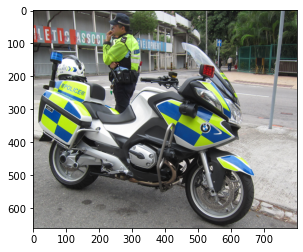

In [17]:
# 이미지 scale이 예측에 영향을 줄수있으니 raw 이미지를 downscale하고
# endpoint으로 보내기

from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = "data/test_resized.jpg"
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

In [ ]:
#endpoint 모델은 비슷한 이미지로 예측 가능함
# Content-Type = image/jpeg
# output Accept = image/jpeg or application/x-protobuf

In [18]:
# Sagemaker SDK의 serializer and deserializer로 통해 API call로 데이터 변환을 control하고 파이썬 result object으로 로딩함
# Basic Inference - class IDs PNG
# simple PNG response를 요청하고, pixel array로 매핑함. 커스텀 deserializer을 만듬:

from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")

In [19]:
#input 데이터가 jpeg파일이라서 built-in IdentitySerializer로
# 파일 byte로 전달

ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

with open(filename, "rb") as imfile:
    imbytes = imfile.read()

# Extension exercise: Could you write a custom serializer which takes a filename as input instead?

In [20]:
# endpoint 호출이 간편하게 됨

#%%time

cls_mask = ss_predictor.predict(imbytes)

print(type(cls_mask))
print(cls_mask.shape)

<class 'numpy.ndarray'>
(660, 799)


#### Segmentation mask 보기

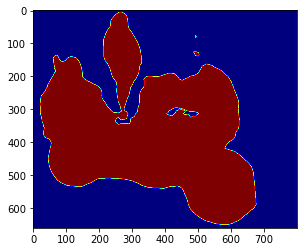

In [21]:
# pixel 단위는 작은 숫자(class ID)이기 떄문에, colormap으로
# 더 잘보이게 만듭니다, 검은색칠로 된 네모로 하는거보다

plt.imshow(cls_mask, cmap="jet")
plt.show()

In [23]:
pip install mxnet

     |████████████████████████████████| 47.3 MB 51 kB/s              
Note: you may need to restart the kernel to use updated packages.


In [24]:
# Advanced inference - class probibilites matrix

import io
import tempfile

import mxnet as mx
from sagemaker.amazon.record_pb2 import Record


class SSProtobufDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize protobuf semantic segmentation response into a numpy array"""

    def __init__(self, accept="application/x-protobuf"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class confidences per pixel
        """
        try:
            rec = Record()
            # mxnet.recordio can only read from files, not in-memory file-like objects, so we buffer the
            # response stream to a file on disk and then read it back:
            with tempfile.NamedTemporaryFile(mode="w+b") as ftemp:
                ftemp.write(stream.read())
                ftemp.seek(0)
                recordio = mx.recordio.MXRecordIO(ftemp.name, "r")
                protobuf = rec.ParseFromString(recordio.read())
            values = list(rec.features["target"].float32_tensor.values)
            shape = list(rec.features["shape"].int32_tensor.values)
            # We 'squeeze' away extra dimensions introduced by the fact that the model can operate on batches
            # of images at a time:
            shape = np.squeeze(shape)
            mask = np.reshape(np.array(values), shape)
            return np.squeeze(mask, axis=0)
        finally:
            stream.close()


ss_predictor.deserializer = SSProtobufDeserializer()

In [25]:
#%%time
prob_mask = ss_predictor.predict(imbytes)

print(type(prob_mask))
print(prob_mask.shape)

<class 'numpy.ndarray'>
(21, 660, 799)


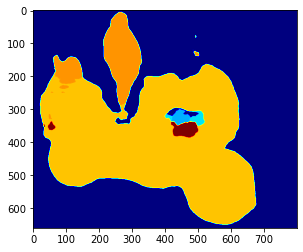

In [26]:
cls_mask_2 = np.argmax(prob_mask, axis=0)

plt.imshow(cls_mask_2, cmap="jet")
plt.show()

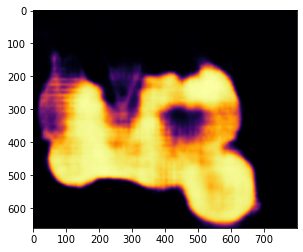

In [27]:
target_cls_id = 14  # (motorbike)
plt.imshow(prob_mask[target_cls_id, :, :], cmap="inferno")
plt.show()

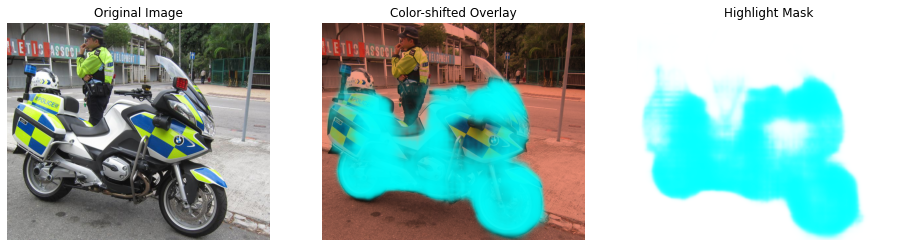

In [28]:
imarray = np.array(PIL.Image.open(filename)) / 255.0  # Convert image pixels from 0-255 to 0-1
hilitecol = np.array((0.0, 1.0, 1.0, 1.0))  # Cyan, 100% opacity (RGBAlpha 0-1 range)

# Red-shift our image to make the cyan highlights more obvious:
imshifted = imarray.copy()
imshifted[:, :, 1] *= 0.6
imshifted[:, :, 2] *= 0.5

# Construct a mask with alpha channel taken from the model result:
hilitemask = np.tile(hilitecol[np.newaxis, np.newaxis, :], list(imarray.shape[:2]) + [1])
hilitemask[:, :, 3] = prob_mask[target_cls_id, :, :]

# Overlay the two images:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 6))

ax0.imshow(imarray)
ax0.axis("off")
ax0.set_title("Original Image")
ax2.imshow(hilitemask)
ax2.axis("off")
ax2.set_title("Highlight Mask")

ax1.imshow(imshifted)
ax1.imshow(hilitemask)
ax1.axis("off")
ax1.set_title("Color-shifted Overlay")

plt.show()

### 다른 테스트 이미지로 sgementation 예측

In [39]:
filename_raw = "data/test2.jpg"

!wget -O $filename_raw http://cdn.cnn.com/cnnnext/dam/assets/211013170227-04-scariest-airport-landings-sint-maarten-restricted.jpg

--2022-04-07 02:06:56--  http://cdn.cnn.com/cnnnext/dam/assets/211013170227-04-scariest-airport-landings-sint-maarten-restricted.jpg
Resolving cdn.cnn.com (cdn.cnn.com)... 184.25.196.202, 2600:1408:5400:497::3134, 2600:1408:5400:499::3134, ...
Connecting to cdn.cnn.com (cdn.cnn.com)|184.25.196.202|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5650598 (5.4M) [image/jpeg]
Saving to: ‘data/test2.jpg’

data/test2.jpg      100%[===================>]   5.39M  32.1MB/s    in 0.2s    

2022-04-07 02:06:56 (32.1 MB/s) - ‘data/test2.jpg’ saved [5650598/5650598]



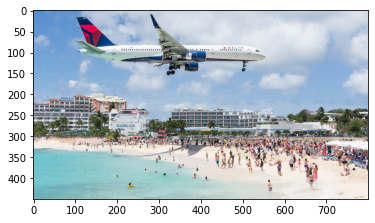

In [40]:
# 이미지 scale이 예측에 영향을 줄수있으니 raw 이미지를 downscale하고
# endpoint으로 보내기

from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = "data/test_resized2.jpg"
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

In [44]:
# Sagemaker SDK의 serializer and deserializer로 통해 API call로 데이터 변환을 control하고 파이썬 result object으로 로딩함
# Basic Inference - class IDs PNG
# simple PNG response를 요청하고, pixel array로 매핑함. 커스텀 deserializer을 만듬:

from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")

In [45]:
#input 데이터가 jpeg파일이라서 built-in IdentitySerializer로
# 파일 byte로 전달

ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

with open(filename, "rb") as imfile:
    imbytes = imfile.read()

# Extension exercise: Could you write a custom serializer which takes a filename as input instead?

In [46]:
# endpoint 호출이 간편하게 됨

#%%time

cls_mask = ss_predictor.predict(imbytes)

print(type(cls_mask))
print(cls_mask.shape)

<class 'numpy.ndarray'>
(450, 800)


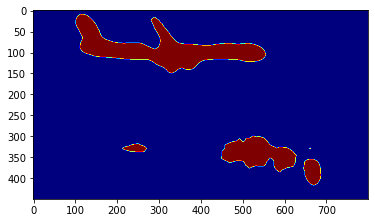

In [47]:
# pixel 단위는 작은 숫자(class ID)이기 떄문에, colormap으로
# 더 잘보이게 만듭니다, 검은색칠로 된 네모로 하는거보다

plt.imshow(cls_mask, cmap="jet")
plt.show()

### 코비 사진 segmentation

In [51]:
filename_raw = "data/kobi.jpg"

#!wget -O $filename_raw C://Users/chohw/Downloads/MicrosoftTeams-image(8).jpg

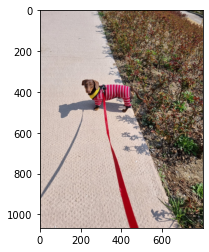

In [52]:
# 이미지 scale이 예측에 영향을 줄수있으니 raw 이미지를 downscale하고
# endpoint으로 보내기

from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = "data/kobi_resized.jpg"
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

In [53]:
# Sagemaker SDK의 serializer and deserializer로 통해 API call로 데이터 변환을 control하고 파이썬 result object으로 로딩함
# Basic Inference - class IDs PNG
# simple PNG response를 요청하고, pixel array로 매핑함. 커스텀 deserializer을 만듬:

from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")

In [54]:
#input 데이터가 jpeg파일이라서 built-in IdentitySerializer로
# 파일 byte로 전달

ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

with open(filename, "rb") as imfile:
    imbytes = imfile.read()

# Extension exercise: Could you write a custom serializer which takes a filename as input instead?

In [55]:
# endpoint 호출이 간편하게 됨

#%%time

cls_mask = ss_predictor.predict(imbytes)

print(type(cls_mask))
print(cls_mask.shape)

<class 'numpy.ndarray'>
(1066, 799)


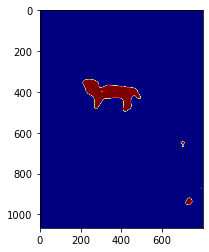

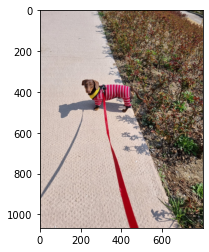

In [57]:
# pixel 단위는 작은 숫자(class ID)이기 떄문에, colormap으로
# 더 잘보이게 만듭니다, 검은색칠로 된 네모로 하는거보다

plt.imshow(cls_mask, cmap="jet")
plt.show()

plt.imshow(im)
plt.show()

### 벛꽃 segmentation

In [28]:
filename_raw = "data/cherry_blossoms.jpg"

#!wget -O $filename_raw C://Users/chohw/Downloads/MicrosoftTeams-image(8).jpg

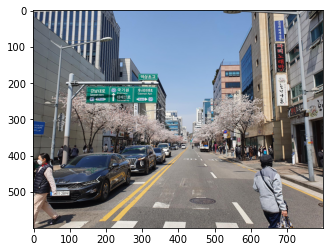

In [29]:
# 이미지 scale이 예측에 영향을 줄수있으니 raw 이미지를 downscale하고
# endpoint으로 보내기

from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = "data/cherry_blossoms_resized.jpg"
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

In [30]:
# Sagemaker SDK의 serializer and deserializer로 통해 API call로 데이터 변환을 control하고 파이썬 result object으로 로딩함
# Basic Inference - class IDs PNG
# simple PNG response를 요청하고, pixel array로 매핑함. 커스텀 deserializer을 만듬:

from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")

In [31]:
#input 데이터가 jpeg파일이라서 built-in IdentitySerializer로
# 파일 byte로 전달

ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

with open(filename, "rb") as imfile:
    imbytes = imfile.read()

# Extension exercise: Could you write a custom serializer which takes a filename as input instead?

In [32]:
# endpoint 호출이 간편하게 됨

#%%time

cls_mask = ss_predictor.predict(imbytes)

print(type(cls_mask))
print(cls_mask.shape)

<class 'numpy.ndarray'>
(600, 800)


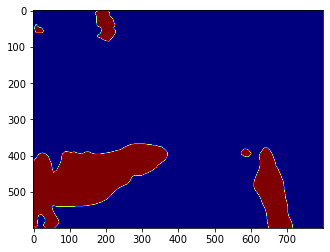

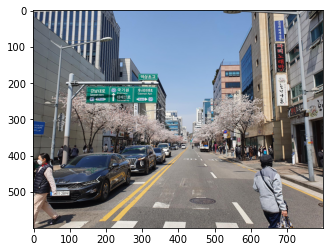

In [33]:
# pixel 단위는 작은 숫자(class ID)이기 떄문에, colormap으로
# 더 잘보이게 만듭니다, 검은색칠로 된 네모로 하는거보다

plt.imshow(cls_mask, cmap="jet")
plt.show()

plt.imshow(im)
plt.show()